<a href="https://colab.research.google.com/github/harry-erskine/PRBX-Travel-Mode-Identification/blob/main/Source%20Code/Support%20Vector%20Machines/ML_Support_Vector_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Support Vector Machines**

### **Data Preferences**

In [ ]:
### VARIABLES ###

groupSize = 64                  # How many trajectories are represented in each group
motion_points = groupSize - 3    # Do not change this variable

# variables below all 'True' or 'False' (where all 'False' represents the most filtered version of the data)

include_impossible_groups = False      # include groups with trajectories that I have deemed to be invalid
include_stationary_groups = False      # include groups where there is less than 3 meters of total movement
include_airplane_and_boat = False      # include groups where the mode of transportation was 'airplane' or 'boat'
include_all_time_ranges = False        # include groups where the time between each trajectory is more than 1 second

### **Notebook Setup**

In [ ]:
### INSTALLS ###

# !pip install --upgrade gspread
# !pip install pandas
# !pip install scikit-learn

In [ ]:
### IMPORTS ###

import os
from google.colab import drive
import pandas as pd
import numpy as np
import time
#
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from mpl_toolkits import mplot3d
from sklearn.metrics import accuracy_score

In [ ]:
### MOUNT GOOGLE DRIVE ###

mainMountPath = '/content/gdrive'
mainDrivePath = '/content/gdrive/MyDrive/Colab Notebooks/PRBX'

drive.mount(mainMountPath, force_remount=True)

Mounted at /content/gdrive


In [ ]:
### FILE PATHS ###

generatedFilesPath = mainDrivePath + '/Data Files/Generated Files'
cleanedMotionDataPath = generatedFilesPath + '/cleanedMotionDataX' + str(groupSize) + '.csv'

In [ ]:
cmdf = pd.read_csv(cleanedMotionDataPath)
cmdf = cmdf.drop('Unnamed: 0', axis=1)

In [ ]:
df = cmdf

if include_impossible_groups == False:
  df = df[df['Impossible'] == False]

if include_stationary_groups == False:
  df = df[df['Stationary'] == False]

if include_airplane_and_boat == False:
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)

if include_all_time_ranges == False:
  df = df[df['DT Max'] == 1]

df = df.reset_index(drop=True)
df

<ipython-input-7-26835d7f0274>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['Mode'] == 'airplane'].index, inplace=True)
<ipython-input-7-26835d7f0274>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['Mode'] == 'boat'].index, inplace=True)


,GroupId,UserId,Mode,Old Mode,S0,S1,S2,S3,S4,S5,...,AA RC6,BR RC0,BR RC1,BR RC2,BR RC3,BR RC4,BR RC5,BR RC6,Impossible,Stationary
0,2,10,walk,walk,0.681000,0.688277,1.038191,0.922671,0.688277,0.884311,...,0,31,15,14,1,0,0,0,False,False
1,3,10,walk,walk,1.248763,1.224931,1.248763,1.038498,1.203524,1.140418,...,2,30,8,17,6,0,0,0,False,False
2,104,10,walk,walk,1.501034,1.407068,1.125654,1.266361,1.125654,1.307975,...,0,42,15,4,0,0,0,0,False,False
3,105,10,walk,walk,0.703532,1.307973,1.074706,1.307973,0.984945,1.125651,...,0,36,21,4,0,0,0,0,False,False
4,107,10,walk,walk,1.321223,0.821160,0.530427,0.703528,0.619698,0.821159,...,0,37,17,5,2,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5741,53542,170,train,subway,16.100029,16.100934,15.770623,15.766923,16.434018,16.658702,...,0,61,0,0,0,0,0,0,False,False
5742,53556,170,train,subway,16.416905,15.831001,15.683350,15.743367,16.265907,16.255995,...,0,61,0,0,0,0,0,0,False,False
5743,53559,170,train,subway,16.700814,16.273080,16.344797,16.451186,16.344802,16.526102,...,0,60,1,0,0,0,0,0,False,False
5744,53560,170,train,subway,19.442885,19.884635,19.524862,19.520053,19.575441,19.380187,...,2,61,0,0,0,0,0,0,False,False


In [ ]:
print(df['Mode'].unique())

['walk' 'train' 'bus' 'bike' 'car']


In [ ]:
# columns_cmdf = cmdf.columns.tolist()

# # Print columns in groups of 20 lines
# for i in range(0, len(columns_cmdf), 10):
#     print(columns_cmdf[i:i+10])

In [ ]:
# Names of raw motion features
raw_speed_features =          [f'S{i}' for i in range(motion_points)]
raw_acceleration_features =   [f'A{i}' for i in range(motion_points)]
raw_jerk_features =           [f'J{i}' for i in range(motion_points)]
raw_alti_velocity_features =  [f'AV{i}' for i in range(motion_points)]
raw_alti_accel_features =     [f'AA{i}' for i in range(motion_points)]
raw_bearing_rate_features =   [f'BR{i}' for i in range(motion_points)]

raw_motion_features = raw_speed_features + raw_acceleration_features + raw_jerk_features + \
                      raw_alti_velocity_features + raw_bearing_rate_features

In [ ]:
# Names of derived motion features
derived_speed_features =          ['S Min', 'S 25% Q', 'S Mean', 'S Median', 'S 75% Q', 'S Max', 'S Range', 'S IQR']
derived_acceleration_features =   ['A Min', 'A 25% Q', 'A Mean', 'A Median', 'A 75% Q', 'A Max', 'A Range', 'A IQR']
derived_jerk_features =           ['J Min', 'J 25% Q', 'J Mean', 'J Median', 'J 75% Q', 'J Max', 'J Range', 'J IQR']
derived_alti_velocity_features =  ['AV Min', 'AV 25% Q', 'AV Mean', 'AV Median', 'AV 75% Q', 'AV Max', 'AV Range', 'AV IQR']
derived_alti_accel_features =     ['AA Min', 'AA 25% Q', 'AA Mean', 'AA Median', 'AA 75% Q', 'AA Max', 'AA Range', 'AA IQR']
derived_bearing_rate_features =   ['BR Min', 'BR 25% Q', 'BR Mean', 'BR Median', 'BR 75% Q', 'BR Max', 'BR Range', 'BR IQR']

# another way of formatting names of derived motion features
min_features =     ['S Min',    'A Min',    'J Min',    'AV Min',    'AA Min',      'BR Min']
q25_features =     ['S 25% Q',  'A 25% Q',  'J 25% Q',  'AV 25% Q',  'AA 25% Q',    'BR 25% Q']
mean_features =    ['S Mean',   'A Mean',   'J Mean',   'AV Mean',   'AA Mean',     'BR Mean']
median_features =  ['S Median', 'A Median', 'J Median', 'AV Median', 'AA Median',   'BR Median']
q75_features =     ['S 75% Q',  'A 75% Q',  'J 75% Q',  'AV 75% Q',  'AA M 25% Q',  'BR 75% Q']
max_features =     ['S Max',    'A Max',    'J Max',    'AV Max',    'AA Max',      'BR Max']
range_features =   ['S Range',  'A Range',  'J Range',  'AV Range',  'AA Range',    'BR Range']
iqr_features =     ['S IQR',    'A IQR',    'J IQR',    'AV IQR',    'AA IQR',      'BR IQR']

derived_motion_features =   derived_speed_features + derived_acceleration_features + derived_jerk_features + \
                            derived_alti_velocity_features + derived_bearing_rate_features

In [ ]:
# Names of range count features
speed_rc_features =         [f'S RC{i}' for i in range(7)]
acceleration_rc_features =  [f'A RC{i}' for i in range(7)]
jerk_rc_features =          [f'J RC{i}' for i in range(7)]
alti_velocity_rc_features = [f'AV RC{i}' for i in range(7)]
alti_accel_rc_features =    [f'AA RC{i}' for i in range(7)]
bearing_rate_rc_features =  [f'BR RC{i}' for i in range(7)]

# Concatenate all range count features
range_counts_features =  speed_rc_features + acceleration_rc_features + jerk_rc_features + \
                        alti_velocity_rc_features + bearing_rate_rc_features

In [ ]:
# Names of all useable features
every_feature = raw_motion_features + derived_motion_features + range_counts_features
print(every_feature)

['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59', 'S60', 'A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'J0', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 'J16', 'J17', 'J18', 'J19', 'J20', 'J21', 'J22', 'J23', 'J24', 

### **SVM v0 (Control Group)**

This version of the SVM will use only raw motion data to show how accurate it can be without any derived values fed into it.

This code was based on: https://www.kaggle.com/code/gideon94/multiclass-classification-svm-knn-dt-comparison

This is the same code base as for 'SVM V1'

In [ ]:
all_features = df[raw_motion_features]
target_feature = df['Mode']
# all_features.head()

In [ ]:
x = all_features.values.astype(float) # returns a numpy array of type float
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_features = pd.DataFrame(x_scaled)
# scaled_features.head()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(scaled_features,target_feature,test_size=0.25,random_state=40)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4309, 305), (1437, 305), (4309,), (1437,))

The overall score for Support Vector machine classifier is: 58.65 

Total processing time: 0.69 minutes



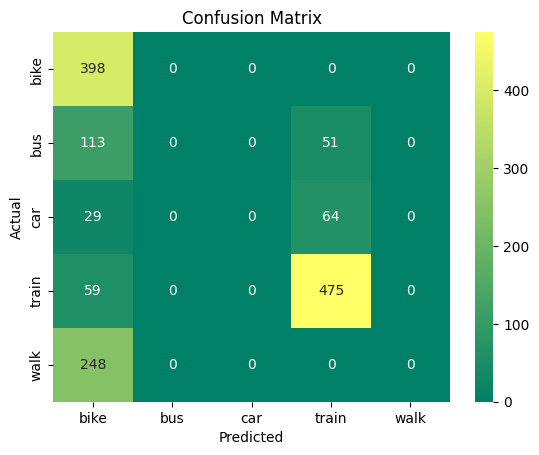

In [ ]:
start_time = time.time()

model = SVC(gamma='auto')
model.fit(X_train,y_train)
pred_svm = model.predict(X_test)
kfold = KFold(n_splits=10) # k=10, split the data into k equal parts
result_svm=cross_val_score(model,scaled_features,target_feature,cv=10,scoring='accuracy')
print('The overall score for Support Vector machine classifier is:',round(result_svm.mean()*100,2),"\n")

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

y_pred = cross_val_predict(model,scaled_features,target_feature,cv=15)

class_labels = model.classes_
sns.heatmap(confusion_matrix(y_test, pred_svm),
            annot=True,
            cmap='summer',
            fmt='g',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# #SVM fold accuracy visualizer
# _result_svm=[r*100 for r in result_svm]
# plt.plot(_result_svm)
# plt.xlabel('Fold')
# plt.ylabel('Accuracy')

### **SVM v1**

In [ ]:
all_features = df[derived_motion_features + range_counts_features]
target_feature = df['Mode']
# all_features.head()

In [ ]:
x = all_features.values.astype(float) #returns a numpy array of type float
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_features = pd.DataFrame(x_scaled)
# scaled_features.head()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(scaled_features,target_feature,test_size=0.2,random_state=40)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4596, 75), (1150, 75), (4596,), (1150,))

The overall score for Support Vector machine classifier is: 77.59 

Total processing time: 0.20 minutes



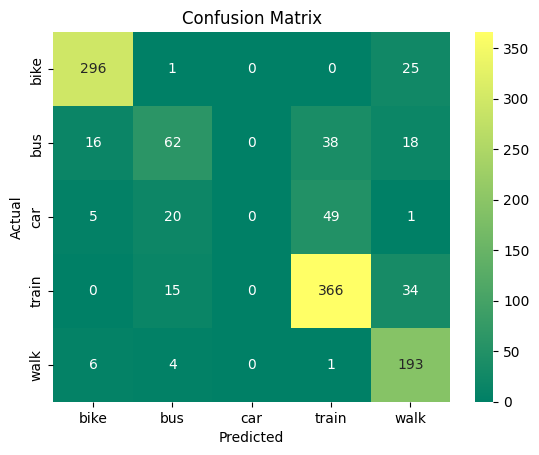

In [ ]:
start_time = time.time()

model = SVC(gamma='auto')
model.fit(X_train,y_train)
pred_svm = model.predict(X_test)
kfold = KFold(n_splits=15) # k=15, split the data into k equal parts
result_svm=cross_val_score(model,scaled_features,target_feature,cv=10,scoring='accuracy')
print('The overall score for Support Vector machine classifier is:',round(result_svm.mean()*100,2),"\n")

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

y_pred = cross_val_predict(model,scaled_features,target_feature,cv=15)

class_labels = model.classes_
sns.heatmap(confusion_matrix(y_test, pred_svm),
            annot=True,
            cmap='summer',
            fmt='g',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Text(0, 0.5, 'Accuracy')

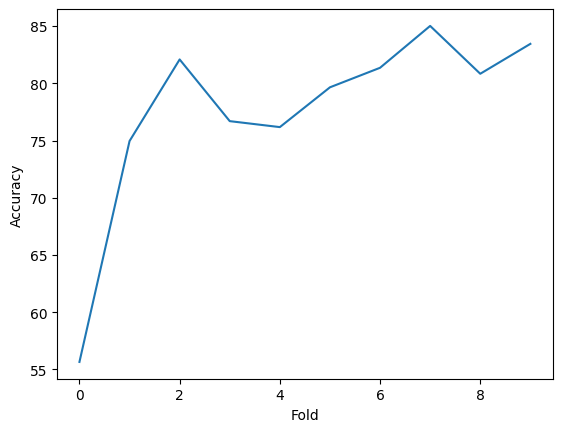

In [ ]:
#SVM fold accuracy visualizer
_result_svm=[r*100 for r in result_svm]
plt.plot(_result_svm)
plt.xlabel('Fold')
plt.ylabel('Accuracy')

### **SVM v2 (with visulisation)**

Code based off of: https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92

#### Pairplot Visualisations

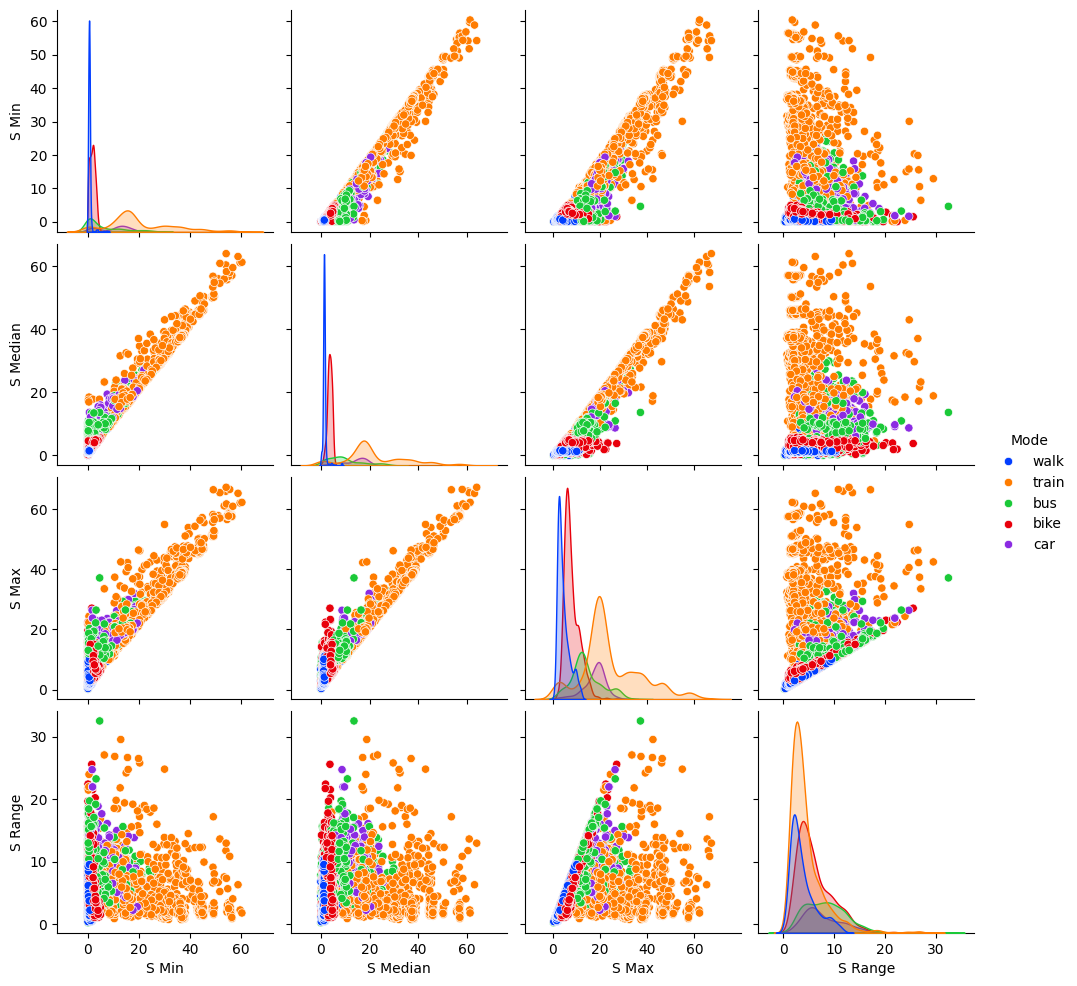

In [ ]:
# # Exclude range and iqr from derived motion and range count features
# features = ['Mode'] + [feature for feature in derived_motion_features
#                        if feature not in range_features + iqr_features]

features = ['Mode', 'S Min','S Median', 'S Max', 'S Range']
data = df[features]
y = data.Mode
X = data.drop('Mode', axis=1)

sns.pairplot(data, hue="Mode", palette="bright")

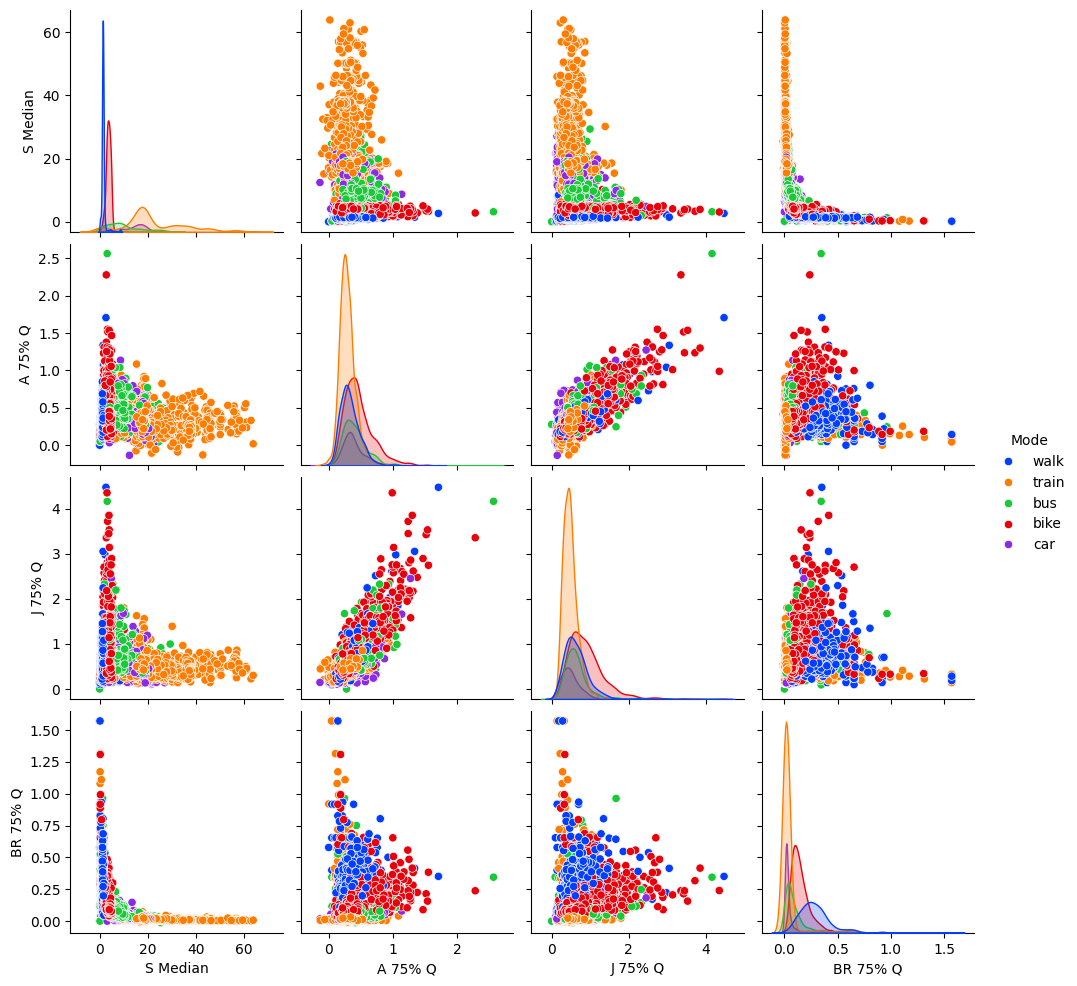

In [ ]:
# show 'Median' features for speed, acceleration, jerk, and bearing rate
features = ['Mode', 'S Median','A 75% Q', 'J 75% Q', 'BR 75% Q']
data = df[features]
y = data.Mode
X = data.drop('Mode', axis=1)

sns.pairplot(data, hue="Mode", palette="bright")

#### SVM Visualisations

In [ ]:
features = ['Mode', 'S Max','A Max']
data = df[features]
data = data[(data['Mode']=='walk') | (data['Mode']=='train')]

# shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# remove data after the 250thth index
data = data.iloc[0:250]

data

,Mode,S Max,A Max
0,train,22.759233,1.469772
1,train,1.326838,1.141769
2,train,13.863617,5.246762
3,train,16.054992,1.506466
4,walk,1.709235,1.241446
...,...,...,...
245,train,18.447828,3.764109
246,train,37.307022,0.994878
247,train,21.419395,2.061180
248,train,19.903328,1.195633


<ipython-input-27-fc85ddf2e49e>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('train', 1)


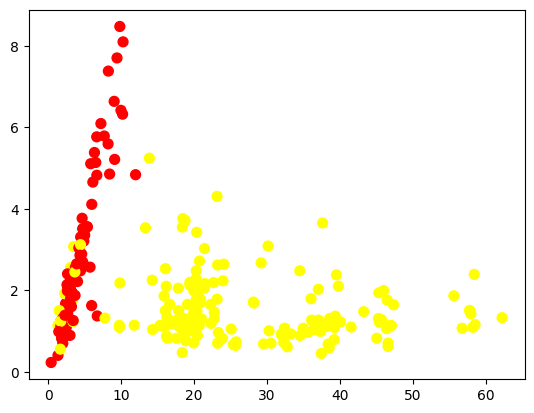

In [ ]:
#let's convert categorical values to numerical target
data = data.replace('walk', 0)
data = data.replace('train', 1)
X = data.iloc[:,1:3]
y = data['Mode']
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')

In [ ]:
start_time = time.time()

model = SVC(kernel='linear', C=1000)
model.fit(X, y)

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

Total processing time: 0.02 minutes



In [ ]:
model.support_vectors_

array([[ 2.47221983,  1.09845338],
       [ 2.33464861,  0.88210723],
       [11.97240232,  4.84108294],
       [ 2.34575939,  0.98615254],
       [10.19405785,  6.3260874 ],
       [ 2.14066173,  0.93676025],
       [ 6.71619538,  1.37518668],
       [ 2.58933025,  0.92930573],
       [ 5.94824857,  1.63028564],
       [ 8.41134848,  4.85711109],
       [ 1.33296506,  0.40803047],
       [ 9.10229473,  5.21636006],
       [ 3.67378261,  1.87981875],
       [ 2.9795807 ,  0.89919641],
       [ 1.98997014,  0.70170225],
       [ 3.18198549,  1.60431116],
       [ 5.73133936,  2.57251033],
       [ 3.42202072,  1.26363619],
       [ 1.32683781,  1.14176856],
       [13.86361739,  5.24676216],
       [ 3.47554822,  3.07925516],
       [ 1.63106497,  1.20634833],
       [ 2.83370919,  1.75337682],
       [ 2.26127616,  1.92155716],
       [ 4.4197015 ,  3.12440023],
       [ 3.04528353,  2.56197628],
       [13.32178818,  3.53839231],
       [ 3.33077775,  1.76625009],
       [ 7.77255661,

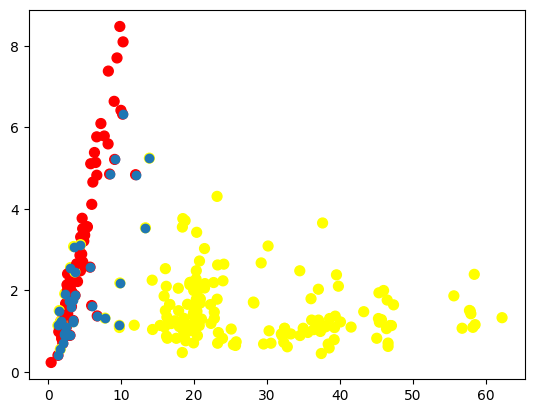

In [ ]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


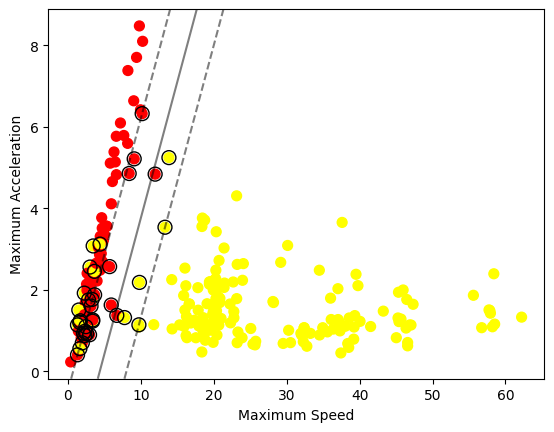

In [ ]:
ax = plt.gca()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel("Maximum Speed")
plt.ylabel("Maximum Acceleration")
plt.show()

In [ ]:
# Predict the labels using the same dataset
y_pred = model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of the model on the entire dataset: {accuracy:.2f}")

Accuracy of the model on the entire dataset: 0.94


In [ ]:

features = ['Mode', 'A Mean', 'BR Mean']
data = df[features]
data = data[(data['Mode']=='walk') | (data['Mode']=='bus')]

# shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# remove data after the 250thth index
data = data.iloc[0:250]

data

,Mode,A Mean,BR Mean
0,walk,0.012020,-0.001555
1,bus,0.130616,0.022321
2,bus,0.173565,-0.020011
3,walk,0.013706,0.015914
4,walk,0.003341,-0.085286
...,...,...,...
245,walk,0.013038,-0.023644
246,walk,-0.018857,0.037488
247,bus,0.076031,-0.007991
248,bus,0.121604,0.131397


<ipython-input-34-75e643223088>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('bus', 1)


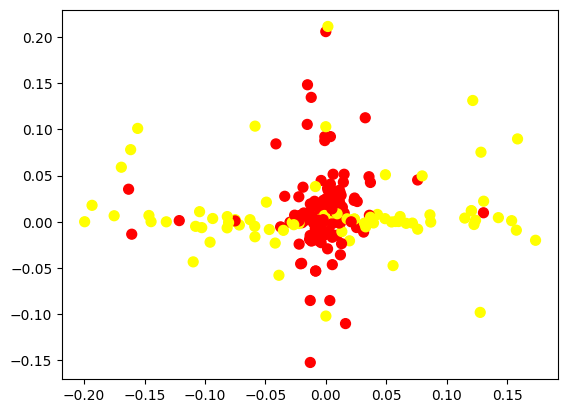

In [ ]:
#let's convert categorical values to numerical target
data = data.replace('walk', 0)
data = data.replace('bus', 1)
X = data.iloc[:,1:3]
y = data['Mode']
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')

In [ ]:
start_time = time.time()

model = SVC(kernel='linear', C=1000)
model.fit(X, y)

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

Total processing time: 0.00 minutes



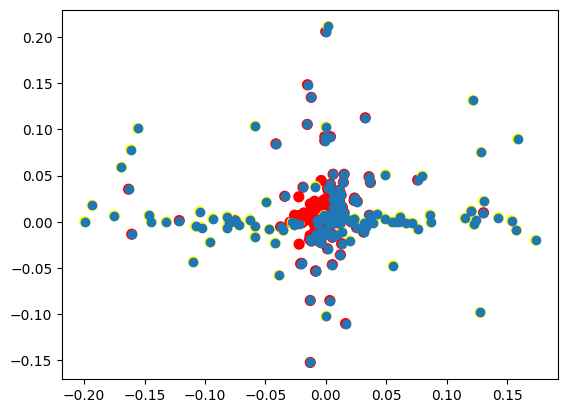

In [ ]:
model.support_vectors_

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


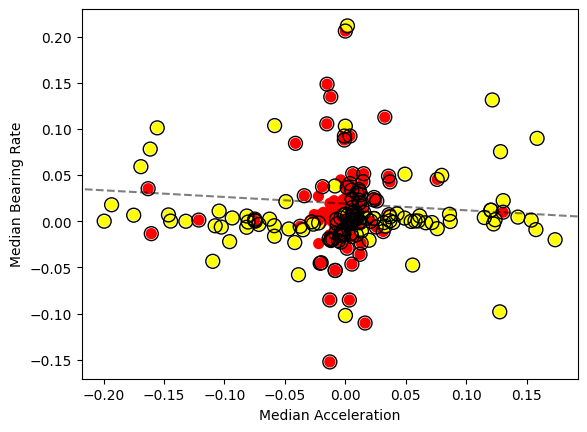

Accuracy of the model on the entire dataset: 0.664


In [ ]:
ax = plt.gca()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel("Median Acceleration")
plt.ylabel("Median Bearing Rate")
plt.show()

# Predict the labels using the same dataset
y_pred = model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of the model on the entire dataset: {accuracy:.3f}")

As you can see this data cannot be split effectively using this method.

But it we apply a certain function to our data it may make the data more seperable.

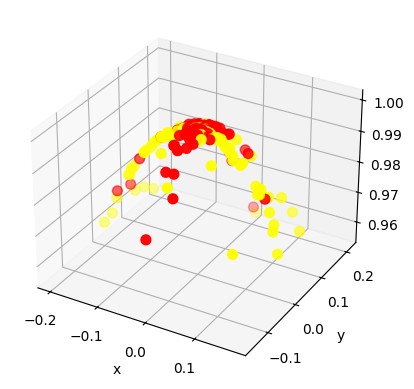

In [ ]:
# Ensure X is a numpy array
X_np = X.values if isinstance(X, pd.DataFrame) else X  # Converting from DataFrame to numpy array if necessary

# Calculate the radial basis function centered on the data
r = np.exp(-(X_np ** 2).sum(1))

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X_np[:, 0], X_np[:, 1], r, c=y, s=50, cmap='autumn')  # Assuming y is your target variable
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r')
plt.show()

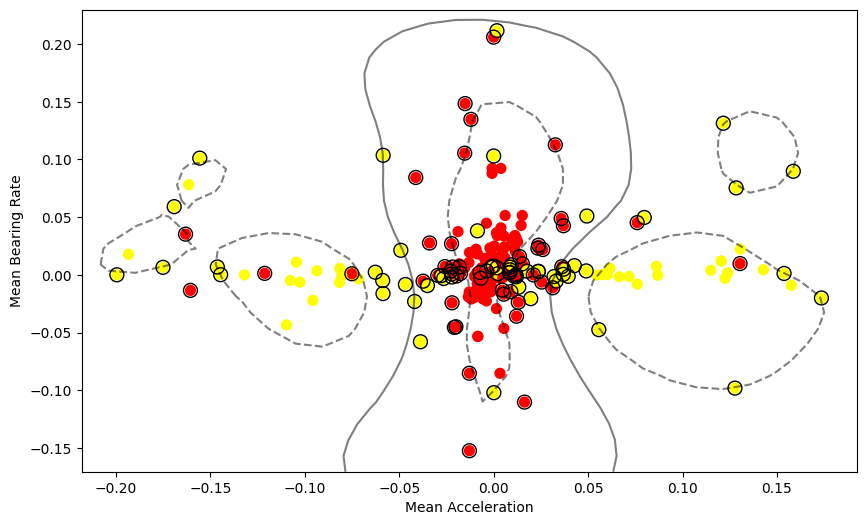

Accuracy of the model on the entire dataset: 0.860


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
model=SVC(kernel='rbf').fit(X, y)

# Ensure X is a numpy array if it comes from a DataFrame
X_np = X.values if isinstance(X, pd.DataFrame) else X
y_np = y.values if isinstance(y, pd.DataFrame) else y

# Fit the model
model = SVC(kernel='rbf').fit(X_np, y_np)

# Plotting setup
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=50, cmap='autumn')

# Setting limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Creating a grid for evaluation
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Highlighting support vectors
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel('Mean Acceleration')
plt.ylabel('Mean Bearing Rate')
#plt.title('SVM Decision Boundary with RBF Kernel')
plt.show()

# Predict the labels using the same dataset
y_pred = model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of the model on the entire dataset: {accuracy:.3f}")

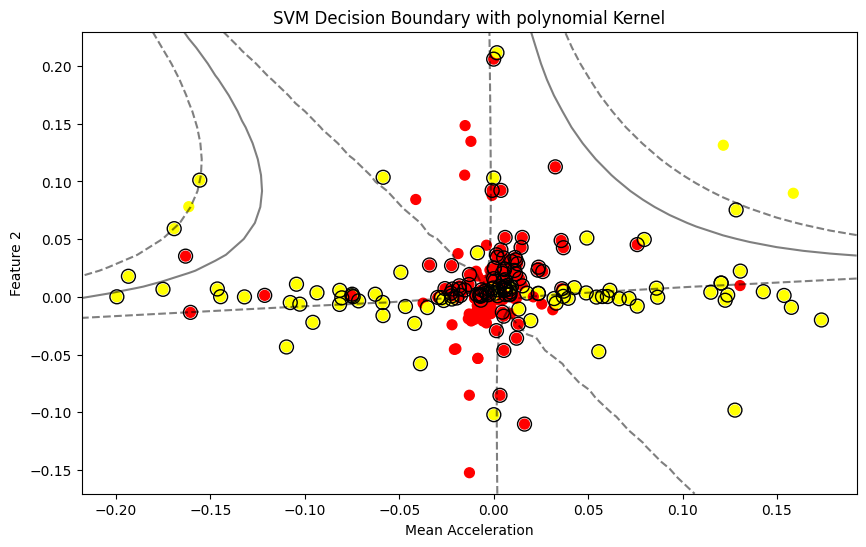

Accuracy of the model on the entire dataset: 0.688


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
model=SVC(kernel='poly').fit(X, y)

# Ensure X is a numpy array if it comes from a DataFrame
X_np = X.values if isinstance(X, pd.DataFrame) else X
y_np = y.values if isinstance(y, pd.DataFrame) else y

# Fit the model
model = SVC(kernel='poly').fit(X_np, y_np)

# Plotting setup
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=50, cmap='autumn')

# Setting limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Creating a grid for evaluation
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Highlighting support vectors
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.xlabel('Mean Acceleration')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with polynomial Kernel')
plt.show()

# Predict the labels using the same dataset
y_pred = model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of the model on the entire dataset: {accuracy:.3f}")

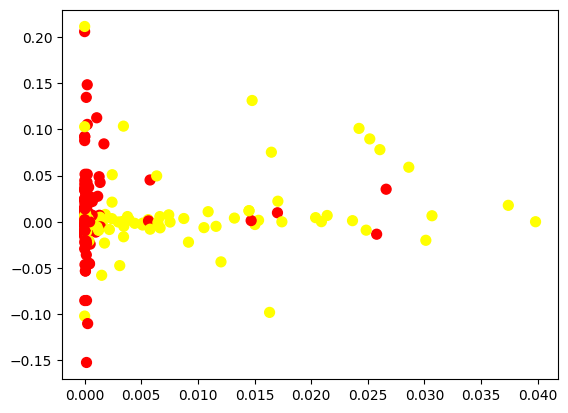

In [ ]:
# Adjust the data so that the acceleration's mean is squared
adjustedDf = data
adjustedDf['A Mean'] = adjustedDf['A Mean'] ** 2

X = adjustedDf.iloc[:,1:3]
y = adjustedDf['Mode']
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')

In [ ]:
start_time = time.time()

model = SVC(kernel='linear', C=100000)
model.fit(X, y)

time_in_mins = (time.time() - start_time) / 60
print(f"Total processing time: {time_in_mins:.2f} minutes\n")

Total processing time: 0.00 minutes



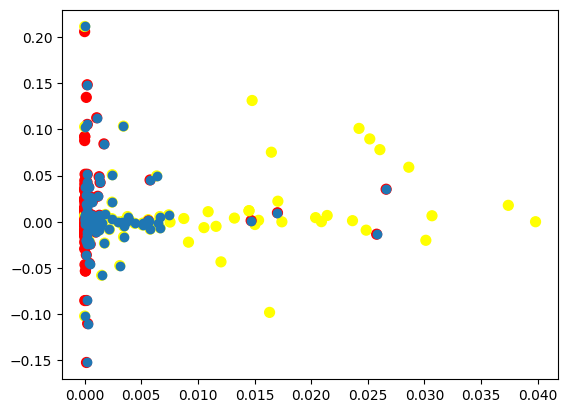

In [ ]:
model.support_vectors_

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


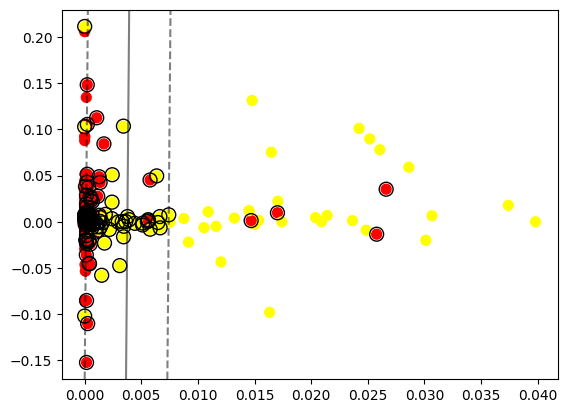

In [ ]:
ax = plt.gca()
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

### Next Step: ML - Convolutional Neural Network